# Introduction

Welcome to the hands-on Colab notebook for TabPFN!
This code shows how to locally (with GPU support) install and run TabPFN. For fast inference with additional features use **[TabPFN client](https://tinyurl.com/tabpfn-colab-online)**.

**Installation**
* First, copy the notebook to be able to modify it.
* Then, run the cells in the installation block, this should
be good enough!

---

> 🔵 **Hint** <br>
We recommend first enabling the **Table of Contents** with the `☰` icon in the top left and collapsing all sections by selecting all cells `Ctrl + Shift + A` and then pressing `Ctrl + ]`.

---

Thank you to [Lennart Purucker](https://github.com/LennartPurucker) for providing the original version of this notebook!

# Installation

Restart your runtime and rerun the *cell*, if Colab asks for it.

In [6]:
# # Install sklearn
# !pip install scikit-learn==1.5.2

# # Install TabPFN
# !pip install tabpfn

# # TabPFN Community installs optional functionalities around the TabPFN model
# # These include post-hoc ensembles, interpretability tools, and more
# !git clone https://github.com/PriorLabs/tabpfn-community
# !pip install -e tabpfn-community[post_hoc_ensembles,interpretability,hpo]

# # Install Baselines
# !pip install catboost xgboost

# # Install example datasets
# !pip install datasets

In [7]:
!git clone https://github.com/PriorLabs/tabpfn-extensions
!pip install -e tabpfn-extensions[post_hoc_ensembles,interpretability,hpo]


fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
Obtaining file:///output/NEW/rebuild_adrd/baseline/TabPFN/tabpfn-extensions
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tabpfn-extensions (pyproject.toml) ... done
  Created wheel for tabpfn-extensions: filename=tabpfn_extensions-0.0.4-0.editable-py3-none-any.whl size=11302 sha256=1978dca6250930da218760a52b4db8d2480db4040e0bda3962edc6df2683c8d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_8gg4omw/wheels/cf/3a/07/12e4246cb881ab2f08f822fe9ada1b87ea2cf7f9bafcb19019
Successfully built tabpfn-extensions
  Attempting uninstall: tabpfn-extensions
    Found existing installation: tabpfn-extensions 0.0.4
    Uninstalling tabpfn-extensions-0.0.4:

**Now Restart the Runtime**

# Necessary Imports for the Notebook

The examples in this notebook require the following imports.
Make sure to run this cell before any other cell.




### In order to get the fastest predictions you need to enable GPUs for the notebook:
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down

In [2]:
import os

# Setup Imports
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import torch

from tabpfn import TabPFNClassifier, TabPFNRegressor

if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')

# Predicting with TabPFN

For our first example, we will use the client to predict on [toy data from scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html).

## Classification

We now compare the classification performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure classification performance using [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). These toy datasets are simple to solve, so the ROC AUC will be very high.

In [ ]:
import warnings
# import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

# from tabpfn_extensions.hpo import (
#     TunedTabPFNRegressor,
#     TunedTabPFNClassifier,
# )

import pandas as pd
import toml
from icecream import ic

# toml_path = '/openbayes/home/NEW/rebuild_adrd/data/toml_files/default_conf_new.toml'
toml_path = '/openbayes/home/NEW/rebuild_adrd/data/adni_dataset/adni.toml'
features_and_labels = toml.load(toml_path)
# ic.enable()
# ic(features_and_labels)

feature_column_name = [key for key in features_and_labels['feature'].keys()]

# train_file_path = '/openbayes/home/NEW/rebuild_adrd/data/nacc_train.csv'
# test_file_path = '/openbayes/home/NEW/rebuild_adrd/data/nacc_test.csv'
train_file_path = '/openbayes/home/NEW/rebuild_adrd/data/adni_quchong.csv'
# test_file_path = '/openbayes/home/NEW/rebuild_adrd/data/adni_quchong.csv'

label_column_name = [key for key in features_and_labels['label'].keys()]

train_data = pd.read_csv(train_file_path)
# test_data = pd.read_csv(test_file_path)

# train:test = 8:2
test_data = train_data[round(train_data.shape[0] * 0.8):]
train_data = train_data[:round(train_data.shape[0] * 0.8)]

# filtered feature column that not exist in train_data
feature_column_name = [column for column in feature_column_name if column in train_data.columns]

for current_name in label_column_name:

    # select X from column name in feature_column_name
    X_train = train_data[feature_column_name]
    X_test = test_data[feature_column_name]

    # select y from column name in label_column_name
    y_train = train_data[current_name]
    y_test = test_data[current_name]

    # print("X_train shape:", X_train.shape)
    # print("y_train shape:", y_train.shape)
    # print("X_test shape:", X_test.shape)
    # print("y_test shape:", y_test.shape)

    row_number_array = [3, 10, 30, 100, 300, 1000, 3000, 10000]

    # if X_train.shape[0] >= 10000:
    #     # sample 10000 rows id in range(0, X_train.shape[0])
    #     sample_index = np.random.choice(X_train.shape[0], 10000, replace=False)
    #     X_train = X_train.iloc[sample_index]
    #     y_train = y_train.iloc[sample_index]

    for row_number in row_number_array:
        torch.cuda.empty_cache()
        classifier = TabPFNClassifier(random_state=42)
        while(True):
            sample_index = np.random.choice(X_train.shape[0], row_number, replace=False)
            X_train_subset = X_train.iloc[sample_index].copy()
            y_train_subset = y_train.iloc[sample_index].copy()

            # clean GPU cache
            assert(X_train_subset.shape[0] != 0)
            # check if X_train_subset contains NaN
            # ic(X_train_subset['MH16BSMOK'].isnull().sum())
            # if y_train_subset not all null break
            if y_train_subset.isnull().sum() != row_number:
                break

        to_drop = []
        for col in X_train_subset.columns:
            # ic(col)
            if X_train_subset[col].isnull().sum() == X_train_subset.shape[0]:
                to_drop.append(col)
        # drop all columns in to_drop
        X_train_subset.drop(columns=to_drop, inplace=True)
        X_new_test = X_test.drop(columns=to_drop, inplace=False)
        # assert(X_train_subset.isnull().sum().sum() == 0)

        ic(row_number)
        classifier.fit(X_train_subset, y_train_subset)
        y_pred = classifier.predict_proba(X_new_test)
        print(y_pred.shape)
        score = roc_auc_score(y_test, y_pred[:, 1] if y_pred.shape[1] > 1 else y_pred[:, 0])
        # print(f"TabPFN [{current_name}] ROC AUC: {score:.4f}")
        print(f"TabPFN [{current_name}] ROC AUC: {score:.4f} with {row_number} rows")

'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)

# Train and evaluate TabPFN
y_pred = TabPFNClassifier(random_state=42).fit(X_train, y_train).predict_proba(X_test)

# Calculate ROC AUC (handles both binary and multiclass)
score = roc_auc_score(y_test, y_pred if len(np.unique(y)) > 2 else y_pred[:, 1])
print(f"TabPFN ROC AUC: {score:.4f}")
'''

/tmp/ipykernel_40460/790673353.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_subset.drop(columns=to_drop, inplace=True)
ic| row_number: 3
ic| _raise_fo: 'fit_transform'
ic| _raise_fo: 'fit_transform'
ic| _raise_fo: 'fit_transform'
ic| _raise_fo: 'fit_transform'
ic| _raise_fo: 'fit_transform'
ic| _raise_fo: 'fit_transform'
ic| _raise_fo: 'fit_transform'
/tmp/ipykernel_40460/790673353.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_subset.drop(columns=to_drop, inplace=True)
ic| row_number: 10
ic| _raise_fo: 'fit_transform'


(664, 1)
TabPFN [NC] ROC AUC: 0.5000 with 3 rows


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['NAType', 'str']

Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

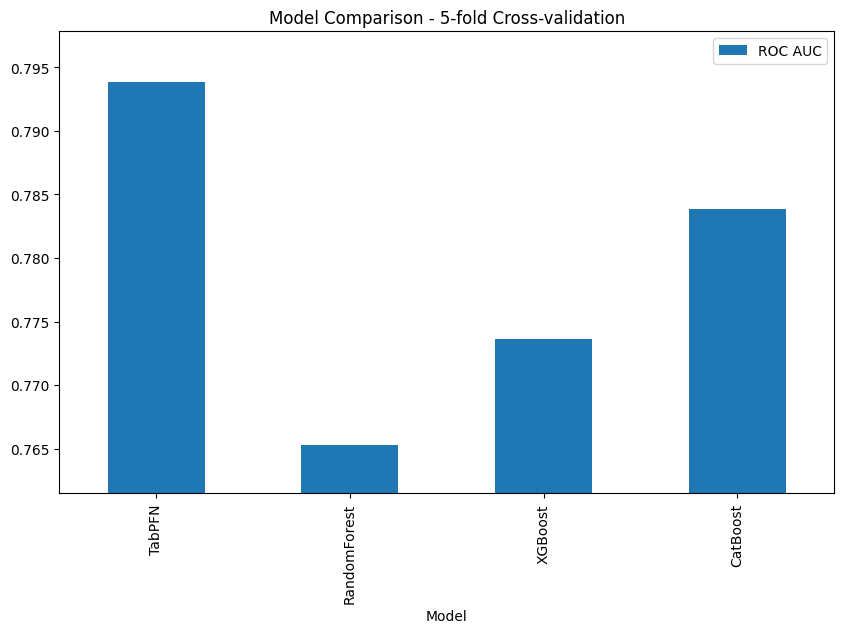

In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ('TabPFN', TabPFNClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

### Best Quality Models (Recommended Use) - Post Hoc Ensembles

In [ ]:
import sys
sys.path.append(os.path.abspath("/openbayes/home/NEW/rebuild_adrd/baseline/TabPFN"))
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

# Binary
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
clf = AutoTabPFNClassifier(max_time=30) # runs for 30 seconds, longer ensembling time leads to better results
clf.fit(X_train, y_train)
prediction_probabilities = clf.predict_proba(X_test)
predictions = np.argmax(prediction_probabilities, axis=-1)

print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))
print("Accuracy", accuracy_score(y_test, predictions))

2025-02-20 03:07:34 INFO     Using `default` preset for Post Hoc Ensemble.
2025-02-20 03:07:34 INFO     No categorical_feature_indices given. Assuming no categorical features.
2025-02-20 03:07:34 INFO     Using task type: TaskType.BINARY
2025-02-20 03:07:34 INFO     Obtaining TabPFN models from a random portfolio.


2025-02-20 03:07:39 INFO     Using 100 base models: ['default_tabpfn_model_0', 'random_tabpfn_model_1', 'random_rf_pfn_model_2', 'random_rf_pfn_model_3', 'random_rf_pfn_model_4', 'random_rf_pfn_model_5', 'random_tabpfn_model_6', 'random_tabpfn_model_7', 'random_rf_pfn_model_8', 'random_tabpfn_model_9', 'random_rf_pfn_model_10', 'random_rf_pfn_model_11', 'random_tabpfn_model_12', 'random_tabpfn_model_13', 'random_rf_pfn_model_14', 'random_rf_pfn_model_15', 'random_rf_pfn_model_16', 'random_tabpfn_model_17', 'random_rf_pfn_model_18', 'random_tabpfn_model_19', 'random_rf_pfn_model_20', 'random_rf_pfn_model_21', 'random_tabpfn_model_22', 'random_rf_pfn_model_23', 'random_rf_pfn_model_24', 'random_tabpfn_model_25', 'random_rf_pfn_model_26', 'random_tabpfn_model_27', 'random_tabpfn_model_28', 'random_tabpfn_model_29', 'random_tabpfn_model_30', 'random_tabpfn_model_31', 'random_tabpfn_model_32', 'random_tabpfn_model_33', 'random_tabpfn_model_34', 'random_tabpfn_model_35', 'random_rf_pfn_model

ROC AUC: 0.9967928950289873
Accuracy 0.973404255319149


## Regression

We now compare the regression performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure regression performance using [Root Mean Squared Error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html).

In [ ]:
# Boston Housing dataset
# Regression task: Predict house prices
# Features: Neighborhood characteristics, housing attributes
# Samples: 506 neighborhoods
# Target: Median house value in $1000s
df = fetch_openml(data_id=531, as_frame=True)

# Alternative datasets (commented for reference):

# Liver Disorders dataset
# Classification task: Predict liver disorder presence
# Features: Blood test results, alcohol consumption
# Samples: 345 patients
# Target: Binary liver disorder diagnosis
# df = fetch_openml("liver-disorders", version=1)

# Grid Stability dataset
# Regression task: Predict electrical grid stability
# Features: Power system measurements, grid parameters
# Samples: 10,000 simulations
# Target: Grid stability score
#df = fetch_openml(data_id=44973, as_frame=True)

# Concrete Compressive Strength dataset
# Regression task: Predict concrete strength
# Features: Concrete components (cement, water, aggregates)
# Samples: 1,030 concrete samples
# Target: Compressive strength in MPa
#df = fetch_openml(data_id=44959, as_frame=True)

X, y = df.data, df.target

# Convert all 'object' and 'category' columns to numeric
for col in X.select_dtypes(['object', 'category']).columns:
    X[col] = pd.factorize(X[col])[0]  # Factorize encodes as integers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print dataset description
display(Markdown(df['DESCR']))

display(X)

/tmp/ipykernel_222011/248323386.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.factorize(X[col])[0]  # Factorize encodes as integers


**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population
MEDV     Median value of owner-occupied homes in $1000's


Information about the dataset
CLASSTYPE: numeric
CLASSINDEX: last

Downloaded from openml.org.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,1,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,1,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,2,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,2,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,0,273.0,21.0,393.45,6.48


In [ ]:
# Train and evaluate TabPFN
reg = TabPFNRegressor(random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Calculate Variance Explained (R2 Score)
score = root_mean_squared_error(y_test, y_pred)
print(f"TabPFN RMSE: {score:.4f}")

TabPFN RMSE: 2.6107


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation \n (Root Mean Squared Error - Smaller is better)')

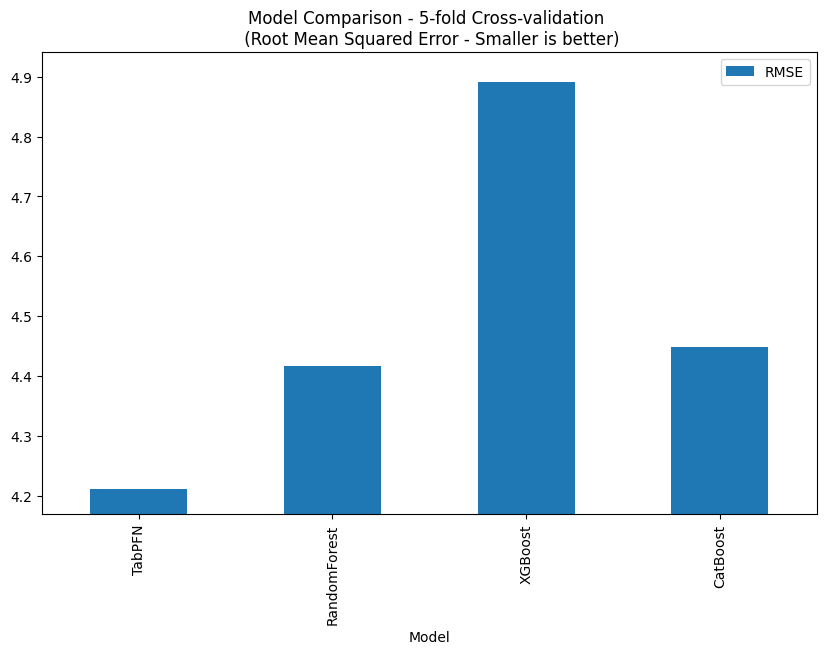

In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ('TabPFN', TabPFNRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'neg_root_mean_squared_error'
scores = {name: cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs=-1).mean()
          for name, model in models}


# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'RMSE'])
df.RMSE = -df.RMSE # Smaller is better
ax = df.plot(x='Model', y='RMSE', kind='bar', figsize=(10, 6))
ax.set_ylim(df['RMSE'].min() * 0.99, df['RMSE'].max() * 1.01)
ax.set_title('Model Comparison - 5-fold Cross-validation \n (Root Mean Squared Error - Smaller is better)')

### Best Quality Models (Recommended Use) - Post Hoc Ensembles

In [ ]:
import sys
sys.path.append(os.path.abspath("/openbayes/home/NEW/rebuild_adrd/baseline/TabPFN"))
from tabpfn_community.post_hoc_ensembles.sklearn_interface import AutoTabPFNRegressor

# Regression
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
)
reg = AutoTabPFNRegressor(max_time=30) # runs for 30 seconds
reg.fit(X_train, y_train)
predictions = reg.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predictions))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predictions))
print("R-squared (R^2):", r2_score(y_test, predictions))

ModuleNotFoundError: No module named 'tabpfn_community'

# Predictive Behavior of TabPFN

In this section, we explore the behavior of predictions from TabPFN on various toy functions.

## Decision Boundary during Classification

First, let us inspect the decision boundary for different classifiers.
The decision bounds show how smoothly a model learns to transition between classes and how well it fits the data.

In the first cell, we create the data and code to plot the decision boundary. The second cell then generates the plot.

In [ ]:
# Toy functions that generate the data
def generate_circle(n_datapoints, radius, noise_factor):
    angles = np.linspace(0, 2*np.pi, n_datapoints).T
    x = radius * np.cos(angles) + np.random.randn(n_datapoints) * noise_factor
    y = radius * np.sin(angles) + np.random.randn(n_datapoints) * noise_factor

    return np.stack([x, y]).T

def generate_concentric_cirlces(radii, num_points_per_circle, noise_factor=1/15):
    circles = []
    for r, num_points in zip(radii, num_points_per_circle):
        circles.append(generate_circle(num_points, r, noise_factor))

    circle = np.vstack(circles)
    return circle

def generate_circle_data(num_points_per_circle, radii, noise_factor):
    radii = np.array(radii)
    circles_1 = generate_concentric_cirlces(radii, num_points_per_circle, noise_factor)
    circles_1 = np.hstack([circles_1, np.zeros((sum(num_points_per_circle) , 1))])

    circles_2 = generate_concentric_cirlces(radii + 0.3, num_points_per_circle, noise_factor)
    circles_2 = np.hstack([circles_2, np.ones((sum(num_points_per_circle), 1))])

    circles = np.vstack([circles_1, circles_2])
    X, y = circles[:, :2], circles[:, 2]
    return X, y

# Generate the data
X_train, y_train = generate_circle_data(
  num_points_per_circle=[50, 100, 200],
  radii=[1,2,4],
  noise_factor=0.1
)

# Function for plotting
def plot_decision_boundary(ax, model, model_name):
    cmap = ListedColormap(["#FF0000", "#0000FF"])
    ax.set_title(model_name)
    DecisionBoundaryDisplay.from_estimator(
        model, X_train[:, :2], alpha=0.6, ax=ax, eps=0.2, grid_resolution=50, response_method="predict_proba", cmap=plt.cm.RdBu,
    )
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train > 0, cmap=cmap)

In [ ]:
rf = RandomForestClassifier().fit(X_train[:, :2], y_train)
xgb = XGBClassifier().fit(X_train[:, :2], y_train)
tabpfn = TabPFNClassifier().fit(X_train[:, :2], y_train)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(7,7))

# Plot Train Points
ax_points = axes[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(["#FF0000", "#0000FF"]))

# Plot Random Forest
ax_rf = axes[0, 1]
plot_decision_boundary(ax_rf, rf, "Random Forest")

# Plot XGBoost
ax_xgb = axes[1, 0]
plot_decision_boundary(ax_xgb, xgb, "XGBoost")

# Plot TabPFN
ax_tabpfn = axes[1, 1]
plot_decision_boundary(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Sin Curve Fitting with Regression

Next, we investigate the curve-fitting behavior of the different models on a sin curve.

In [ ]:
# Toy function to generate data
def generate_sinx_plus_x(N):
    x = np.linspace(0, 20, N)
    y = np.sin(x) + x/10

    return x.reshape(-1, 1), y

# Utility function for plotting
def plot_predictions(ax, model, model_name):
    X_test = np.linspace(0, 20, 200).reshape(-1, 1) # Predict for 200 points  between 0 and 20
    y_preds = model.predict(X_test)
    ax.set_title(model_name)
    ax.scatter(X_test, y_preds, label="Predictions")
    ax.scatter(X_train, y_train, label="Train points")
    ax.legend()

# Generate data
X_train, y_train = generate_sinx_plus_x(N=40)

# Fit Models
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(random_state=42).fit(X_train, y_train)
tabpfn = TabPFNRegressor()
tabpfn.fit(X_train, y_train)

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot train points
ax_points = axs[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(X_train, y_train, label="Train points")
ax_points.legend()

# Plot predictions for Random Forest
ax_rf = axs[0, 1]
plot_predictions(ax_rf, rf, "Random Forest")

# Plot predictions for XGBoost
ax_xgb = axs[1, 0]
plot_predictions(ax_xgb, xgb, "XGBoost")

# Plot predictions for TabPFN
ax_tabpfn = axs[1, 1]
plot_predictions(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Uncertainty of TabPFN / Quantile Regresison

---



TabPFN is trained to predict the distribution of the target variable and not just a single point. This is also the case for regression.

As a result, we natively obtain uncertainty for the predictions of TabPFN (without the need for a new model or repeating models for different quantiles).

In the following, we plot the uncertainty of TabPFN for a toy function with noise.

In [ ]:
### Code to generate the plot (feel free to ignore)
def plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, full_preds, color_multiplier=5):
  all_quantiles = preds[f"quantiles"]
  y = np.array(all_quantiles) # shape of y: (9, number of samples)

  # Calculate the maximum and minimum values in y
  y_max = np.max(y, axis=0)
  y_min = np.min(y, axis=0)

  # Calculate the widths of each quantile bin
  quantile_bin_widths = np.diff(y, axis=0) # shape of quantile_bin_widths: (8, number of samples)

  # Normalize the bin widths for a given x
  per_x_normalized_bin_widths = (quantile_bin_widths) / (y_max - y_min)

  # Plotting
  num_bins, num_data_points = per_x_normalized_bin_widths.shape[0], per_x_normalized_bin_widths.shape[1]
  rect_width = (x_test[1] - x_test[0]).squeeze() # assuming the x query points are equally spaced out

  for i in range(num_data_points):
      for j in range(num_bins):
          rect_height = quantile_bin_widths[j, i]
          rect = plt.Rectangle(
                    xy=(x_test[i][0] - rect_width / 2, y[j, i]),
                    width=rect_width,
                    height=quantile_bin_widths[j, i],
                    facecolor=plt.cm.viridis(per_x_normalized_bin_widths[j, i] * color_multiplier),
                    edgecolor='none'
                )
          ax.add_patch(rect)

  # Set limits and labels
  ax.plot(x, y_line, label='True line', color='blue')
  ax.set_xlim(min(x_test) - 1, max(x_test) + 1)
  ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')

  # ax.plot(x, y, label='True line', color='blue')
  ax.scatter(x, y_noisy, label='Noisy data', color='red', s=10)

  plt.title('TabPFN Regression Uncertainty')
  plt.show()

# Generate Data
def generate_line_with_heteroscedastic_noise(m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1):
    x = np.linspace(x_start, x_end, num_points)
    noise = np.random.randn(num_points)
    y = m * x
    y_noisy = y + (noise * noise_factor * x)

    return x.reshape(-1, 1), y, y_noisy

def generate_line_with_heteroscedastic_noise_with_gap(m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1):
    extra_points = num_points // 3
    x, y, y_noisy = generate_line_with_heteroscedastic_noise(m, num_points+extra_points, x_start, x_end, noise_factor)
    a = np.arange(num_points + extra_points)
    idx = np.where((a < num_points/3) | (a > num_points/3 + extra_points))
    return x[idx], y[idx], y_noisy[idx]

x, y_line, y_noisy = generate_line_with_heteroscedastic_noise_with_gap(0.8)
x_test = np.linspace(0, 100, 200).reshape(-1, 1)

In [ ]:
reg = TabPFNRegressor()
reg.fit(x, y_noisy)
preds = reg.predict(x_test, output_type="full")

In [ ]:
fig = plt.figure(figsize=(12,6))

# Plot the original data
ax = fig.add_subplot(121)
ax.plot(x, y_line, label='True line', color='blue')
ax.scatter(x, y_noisy, label='Noisy data', color='red', s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(min(x) - 1, max(x) + 1)
ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
ax.set_title('Heteroscedastic Noise along a Sloping Line')
ax.legend()

# plot the uncertainty estimates obtained from TabPFN
ax = fig.add_subplot(122)
plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, preds, color_multiplier=5)

## BATMAN

Na na na na

na na na na

na na na na na

Batman

In [ ]:
# "Just run this, no questions" - Batman
!wget -nc https://github.com/PriorLabs/TabPFNDemoFiles/raw/main/thebat.npy # download a file we need

def sample_random_points(n, array, seed):
    np.random.seed(seed)
    x, y = np.random.randint(0, array.shape[1], (n,)), np.random.randint(0, array.shape[0], (n,))
    return np.vstack((x, y)).T, array[y, x].reshape(-1, 1).flatten()

def plot_for_all_models(n_train_points, data_source="thebat.npy", random_state=9001):
    # Load the data
    data_array = np.load(data_source)
    X_train, y_train = sample_random_points(n_train_points, data_array, random_state)

    # Fit models
    xgb = XGBClassifier(random_state=42).fit(X_train, y_train)
    catboost = CatBoostClassifier(random_state=42, verbose=0).fit(X_train, y_train)
    tabpfn = TabPFNClassifier()
    tabpfn.fit(X_train, y_train)

    ####### PLOTTING  #######
    cmap = ListedColormap(["black", "yellow"])
    def plot_decision_boundary(ax, model, model_name):
        ax.set_title(model_name)
        ax.set_aspect("equal")
        DecisionBoundaryDisplay.from_estimator(
            model, X_train, alpha=0.8, ax=ax, eps=0.2, grid_resolution=50, response_method="predict_proba", cmap=cmap
        )
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train > 0, cmap=cmap)

    fig = plt.figure(figsize=(32,8))

    ### Plot Train Points ###
    ax_points = fig.add_subplot(141)
    ax_points.set_title(f"Train points ({n_train_points})")
    ax_points.set_aspect("equal")
    ax_points.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)

    ### Plot XGBoost ###
    ax_xgb = fig.add_subplot(142)
    plot_decision_boundary(ax_xgb, xgb, "XGBoost")

    ### Plot Random Forest ###
    ax_catboost = fig.add_subplot(143)
    plot_decision_boundary(ax_catboost, catboost, "CatBoost")

    ### Plot TabPFN ###
    ax_tabpfn = fig.add_subplot(144)
    plot_decision_boundary(ax_tabpfn, tabpfn, "TabPFN")

plot_for_all_models(n_train_points=2500, data_source="thebat.npy", random_state=9001)

## Random Search

In [ ]:
from tabpfn_community.hpo import (
    TunedTabPFNRegressor,
    TunedTabPFNClassifier,
)

# Binary
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
clf = TunedTabPFNClassifier()
clf.fit(X_train, y_train)
prediction_probabilities = clf.predict_proba(X_test)
predictions = np.argmax(prediction_probabilities, axis=-1)

print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))
print("Accuracy", accuracy_score(y_test, predictions))

# Multiclass
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
)
clf = TunedTabPFNClassifier()
clf.fit(X_train, y_train)
prediction_probabilities = clf.predict_proba(X_test)
predictions = np.argmax(prediction_probabilities, axis=-1)

print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities, multi_class="ovr"))
print("Accuracy", accuracy_score(y_test, predictions))

# Regression
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
)
reg = TunedTabPFNRegressor()
reg.fit(X_train, y_train)
predictions = reg.predict(X_test)
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predictions))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predictions))
print("R-squared (R^2):", r2_score(y_test, predictions))

# Interpretability

## SHAP

In [ ]:
from tabpfn_community import interpretability

# Load example dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
n_samples = 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5
)

# Initialize and train model
clf = TabPFNClassifier()
clf.fit(X_train, y_train)

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization
fig = interpretability.shap.plot_shap(shap_values)


## Feature selection

In [ ]:
from tabpfn_community import interpretability

# Load data
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Initialize model
clf = TabPFNClassifier(n_estimators=3)

# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=clf,
    X=X,
    y=y,
    n_features_to_select=5,
    feature_names=feature_names
)

# Print selected features
selected_features = [feature_names[i] for i in range(len(feature_names)) if sfs.get_support()[i]]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")

# Unsupervised

## Data Generation / Outlier Detection

In [ ]:
from tabpfn_community import unsupervised

# Load and prepare breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df['data'], df['target']
feature_names = df['feature_names']

# Initialize TabPFN models
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=TabPFNClassifier(),
    tabpfn_reg=TabPFNRegressor()
)

# Select features for synthetic data generation
# Example features: [mean texture, mean area, mean concavity]
feature_indices = [4, 6, 12]

# Run synthetic data generation experiment
experiment = unsupervised.experiments.GenerateSyntheticDataExperiment(
    task_type='unsupervised'
)

results = experiment.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=feature_names,
    temp=1.0,  # Temperature parameter for sampling
    n_samples=X.shape[0] * 2,  # Generate twice as many samples as original data
    indices=feature_indices
)

## Outlier detection

In [ ]:
import torch
from sklearn.datasets import load_breast_cancer
from tabpfn_community import unsupervised
from tabpfn_community import TabPFNClassifier, TabPFNRegressor

# Load data
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
attribute_names = df["feature_names"]

# Initialize models
clf = TabPFNClassifier(n_estimators=4)
reg = TabPFNRegressor(n_estimators=4)
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf, tabpfn_reg=reg
)

# Run outlier detection
exp_outlier = unsupervised.experiments.OutlierDetectionUnsupervisedExperiment(
    task_type="unsupervised"
)
results = exp_outlier.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=attribute_names,
    indices=[4, 12],  # Analyze features 4 and 12
)